In [8]:
import pickle
import cv2 as cv
import matplotlib.pyplot as plt

with open("lane_polynomials.obj", "rb") as f:
    d = pickle.load(f)
    
    print(d)

{'./final_5/proc_0141.png': {'coefficients': array([ 8.94034514e-04, -2.46656777e-01,  2.15034113e+01, -4.70173375e+02]), 'y': [66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103], 'x': array([131, 132, 132, 132, 133, 133, 133, 132, 132, 132, 131, 131, 130,
       130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 120, 118, 117,
       116, 115, 114, 113, 111, 110, 109, 108, 107, 106, 105, 104],
      dtype=int32)}, './final_5/proc_0802.png': {'coefficients': array([-1.15740741e-03,  2.80976173e-01, -2.21873593e+01,  6.79205800e+02]), 'y': [72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103], 'x': array([106, 106, 106, 107, 107, 108, 108, 109, 109, 110, 110, 111, 112,
       112, 113, 113, 113, 114, 114, 114, 114, 114, 114, 114, 114, 114,
       113, 113, 112, 112, 111, 110], dtype=int32)}, './final_5/proc

In [9]:
import numpy as np
import h5py

filename = "camera_intrinsics.h5"
filenameEx = "extrinsics.h5"
main_K, main_distortion = None, None
with h5py.File(filename, "r") as data:

    main_K = np.array(data["main"]["K"])
    main_distortion = np.array(data["main"]["distortion"])

#get the main camera extrinsics

with h5py.File(filenameEx,"r") as data:
    main_ex = np.array(data["main"])



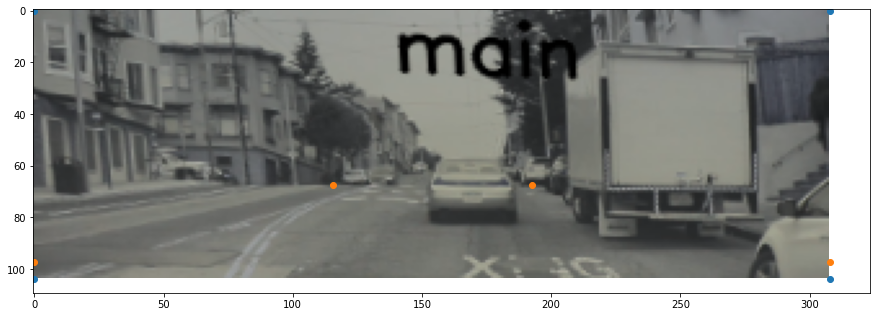

In [124]:
img = cv.imread("proc_main/proc_0848.png")
plt.figure(figsize = (15, 12))
plt.imshow(img)

img_size = (img.shape[1],img.shape[0])

bot_width = 1 # percentage of bottom trapezoidal height
mid_width = .25 # percentage of mid trapezoidal height
height_pct = .65 # percentage of trapezoidal height
bottom_trim= .935 # percentage from top to bottom avoiding the hood of the car

src = np.float32([[img.shape[1]*(0.5-mid_width/2), img.shape[0]*height_pct],[img.shape[1]*(0.5+mid_width/2),img.shape[0]*height_pct],[img.shape[1]*(0.5+bot_width/2), img.shape[0]*bottom_trim],[img.shape[1]*(0.5-bot_width/2), img.shape[0]*bottom_trim]])
offset = img_size[0]*0.25
dst = np.float32([[0,0],[img_size[0],0],[img_size[0],img_size[1]],[0,img_size[1]]])

plt.plot(dst[:, 0], dst[:, 1], "o")
plt.plot(src[:, 0], src[:, 1], "o")

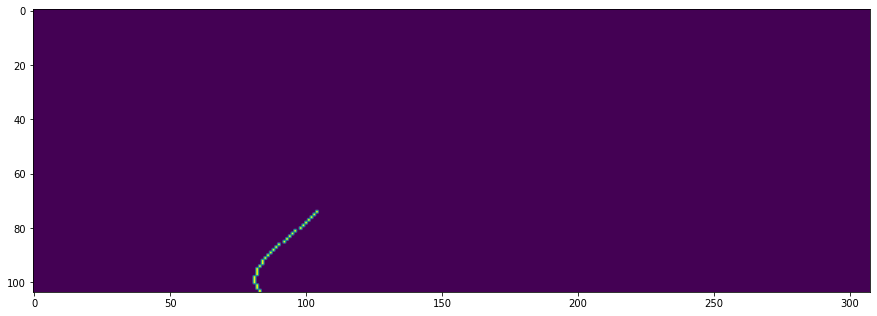

In [125]:
col = d['./final_5/proc_0848.png']['x']
row = d['./final_5/proc_0848.png']['y']

h, w, l = img.shape
new_img = np.zeros((h, w), np.uint8)


for i in range(len(row)):
    new_img[row[i], col[i]] = 1   

plt.figure(figsize = (15, 12))
plt.imshow(new_img)

[-0.0745772   0.01507948  0.99710125]


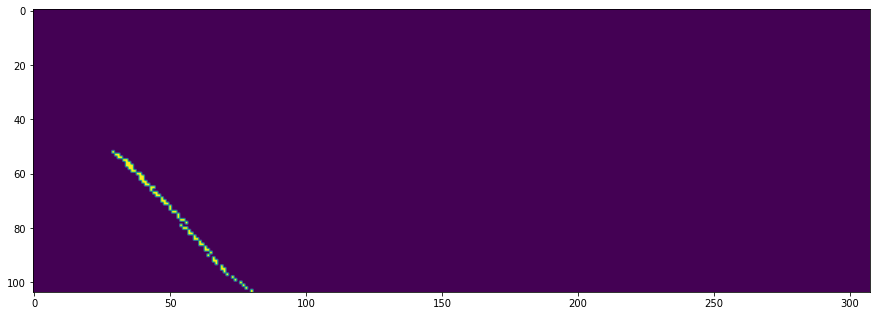

In [126]:
M = cv.getPerspectiveTransform(src, dst)
warped = cv.warpPerspective(new_img, M, (new_img.shape[1], new_img.shape[0]))

plt.figure(figsize = (15, 12))
plt.imshow(warped)

#Conversion: 3 inches (0.075 m) to 4 pixels

# print(main_K)
# print(R)
print(np.matmul(R.T, np.array([1, 0, 0]).T))

(0.0, 7.0)

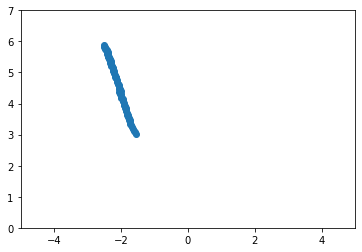

In [128]:

R = main_ex[0:3, 0:3]
T = main_ex[0:3, 3]

T = [T[1], T[0], T[2]]


warped_pts = np.array([[.075 * (col - 160) / 4, 3 * .075 * (120 - row) / 4, 0] for col in range(warped.shape[1]) for row in range(warped.shape[0]) if warped[row, col] == 1])
warped_pts += T
plt.plot(warped_pts[:, 0], warped_pts[:, 1], "o")

plt.xlim(-5, 5)
plt.ylim(0, 7)

[128  81]


Text(0.5, 1.0, 'XY Points in Car Frame')

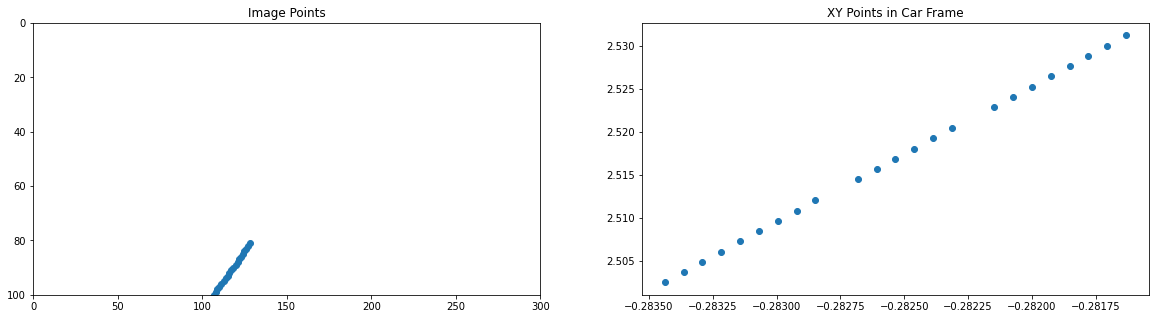

In [107]:
import matplotlib.pyplot as plt

# def uvtoXYZ(u, v):
#     image_vec = np.array([u, v, 1]).T # 2D points in image
#     n = np.array([0, 0, 1]).T  #or is it [0,1,0]? .. normal vector in car/road frame
    
#     h = 1.4660132 # height of main cam (z tranlastion in extrinsic)
    
#     n_c = np.matmul(R_ex, n) #normal vector in cam frame

#     V = h/(np.matmul(n_c.T ,np.matmul(np.linalg.inv(main_K),image_vec)))

#     pts_in_camera_frame = V * np.matmul(np.linalg.inv(main_K),image_vec)
#     return pts_in_camera_frame




def uvtoXYZ(col, row):
    
    u = col - w/2
    v = h/2 - row

    image_vec = np.array([u, v, 1])
    cam_pt = np.matmul(np.linalg.inv(main_K), image_vec)  
    car_pt = np.matmul(R, cam_pt - T)
    
    return car_pt





test_points = np.array([[col[i], row[i]] for i in range(len(row))  if row[i] > 80])
xyz = np.array([uvtoXYZ(pt[0], pt[1]) for pt in test_points])


print(test_points[0])


fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].plot(test_points[:, 0], test_points[:, 1], "o")
ax[0].set_xlim(0, 300)
ax[0].set_ylim(0, 100)
ax[0].set_title("Image Points")
ax[0].invert_yaxis()

ax[1].plot(xyz[:, 0], xyz[:, 1], "o")
ax[1].set_title("XY Points in Car Frame")
# ax[1].set_xlim(-3, 3)
# ax[1].set_ylim(0, max(xyz[:, 1]) + 1)

In [22]:
import h5py
filename = "camera_intrinsics.h5"

with h5py.File(filename, "r") as data:
    
    for group in data.keys() :
        print (group)
        print(data[group])
        for dset in (data[group]).keys() :
            print (dset)
            ds_data = data[group][dset] # returns HDF5 dataset object
            print (ds_data)
            print (ds_data.shape, ds_data.dtype)
            arr = data[group][dset][:] # adding [:] returns a numpy array
            print (arr.shape, arr.dtype)
            print (arr)

fisheye
<HDF5 group "/fisheye" (2 members)>
K
<HDF5 dataset "K": shape (3, 3), type "<f8">
(3, 3) float64
(3, 3) float64
[[316.70483398   0.         320.        ]
 [  0.         317.71963501 240.        ]
 [  0.           0.           1.        ]]
distortion
<HDF5 dataset "distortion": shape (4,), type "<f8">
(4,) float64
(4,) float64
[-0.03342642  0.00159359  0.00044937  0.        ]
leftpillar
<HDF5 group "/leftpillar" (2 members)>
K
<HDF5 dataset "K": shape (3, 3), type "<f8">
(3, 3) float64
(3, 3) float64
[[426.77026367   0.         320.        ]
 [  0.         428.63354492 240.        ]
 [  0.           0.           1.        ]]
distortion
<HDF5 dataset "distortion": shape (4,), type "<f8">
(4,) float64
(4,) float64
[-0.0290205 -0.0940016  0.0307206  0.       ]
leftrepeater
<HDF5 group "/leftrepeater" (2 members)>
K
<HDF5 dataset "K": shape (3, 3), type "<f8">
(3, 3) float64
(3, 3) float64
[[504.37918091   0.         320.        ]
 [  0.         506.87445068 240.        ]
 [  0.   